Model Training

In [13]:
import zipfile
import os

zip_path = '/content/Dataset_BUSI_with_GT.zip'  # or wherever the file is located
extract_path = '/content/Dataset_BUSI_with_GT'

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [14]:
!pip install -q tensorflow seaborn


In [16]:
import os
import glob
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow + Keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential # Use tensorflow.keras.models
from tensorflow.keras.layers import Flatten, Dense, Dropout # Use tensorflow.keras.layers
from tensorflow.keras.applications.densenet import DenseNet121 # Use tensorflow.keras.applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint # Use tensorflow.keras.callbacks
from sklearn.model_selection import train_test_split
from IPython.display import Image as IPImage


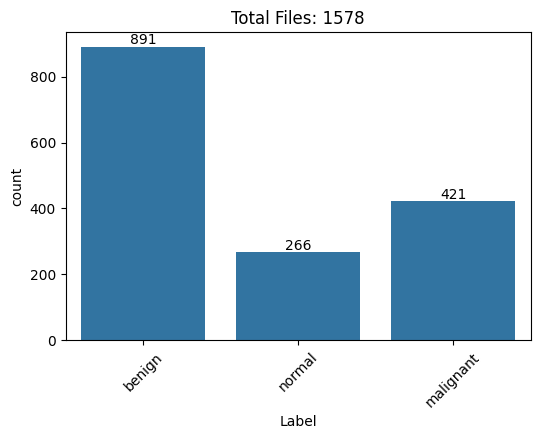

In [17]:
train_data = '/content/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT'

train_files = [i for i in glob.glob(train_data + "/*/*")]
np.random.shuffle(train_files)
labels = [os.path.dirname(i).split("/")[-1] for i in train_files]
training_data = pd.DataFrame(list(zip(train_files, labels)), columns=["Path", "Label"])

# Visualize
plt.figure(figsize=(6,4))
ax = sns.countplot(x=training_data["Label"])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.xticks(rotation=45)
plt.title(f'Total Files: {len(training_data)}')
plt.show()


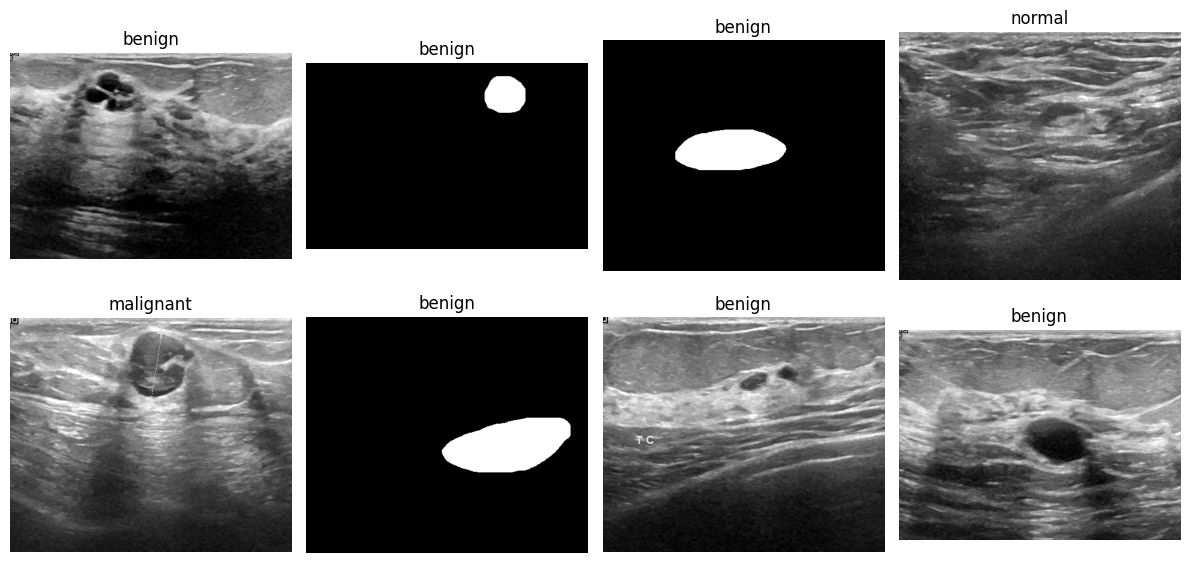

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = Image.open(training_data.iloc[i]["Path"])
    ax.imshow(img)
    ax.set_title(training_data.iloc[i]["Label"])
    ax.axis("off")
plt.tight_layout()
plt.show()


In [19]:
batch_size = 16
image_size = (256, 256)

train_df, val_test_df = train_test_split(training_data, train_size=0.8, shuffle=True, random_state=123)
val_df, test_df = train_test_split(val_test_df, train_size=0.5, shuffle=True, random_state=123)

datagen = ImageDataGenerator(rescale=1.0/255)

train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)

train_generator = datagen.flow_from_dataframe(train_df, x_col='Path', y_col='Label',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True)

valid_generator = datagen.flow_from_dataframe(val_df, x_col='Path', y_col='Label',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True)

class_labels = list(train_generator.class_indices.keys())
print("Class Labels:", class_labels)


Found 1262 validated image filenames belonging to 3 classes.
Found 158 validated image filenames belonging to 3 classes.
Class Labels: ['benign', 'malignant', 'normal']


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# Load the base DenseNet121 model with pre-trained ImageNet weights
# Note: include_top=False excludes the fully connected output layers of the original model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers so they are not trainable
for layer in base_model.layers:
    layer.trainable = False

# Build the full model using Sequential API
model = Sequential([
    Input(shape=(256, 256, 3)),    # Explicit input layer for the Sequential model
    base_model,                    # Pretrained base model
    Flatten(),                     # Flatten output from base model
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # Final output layer (3 classes)
])

# Print model summary to verify
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │      67,109,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,787,843 (289.11 MB)

 Trainable params: 68,750,339 (262.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

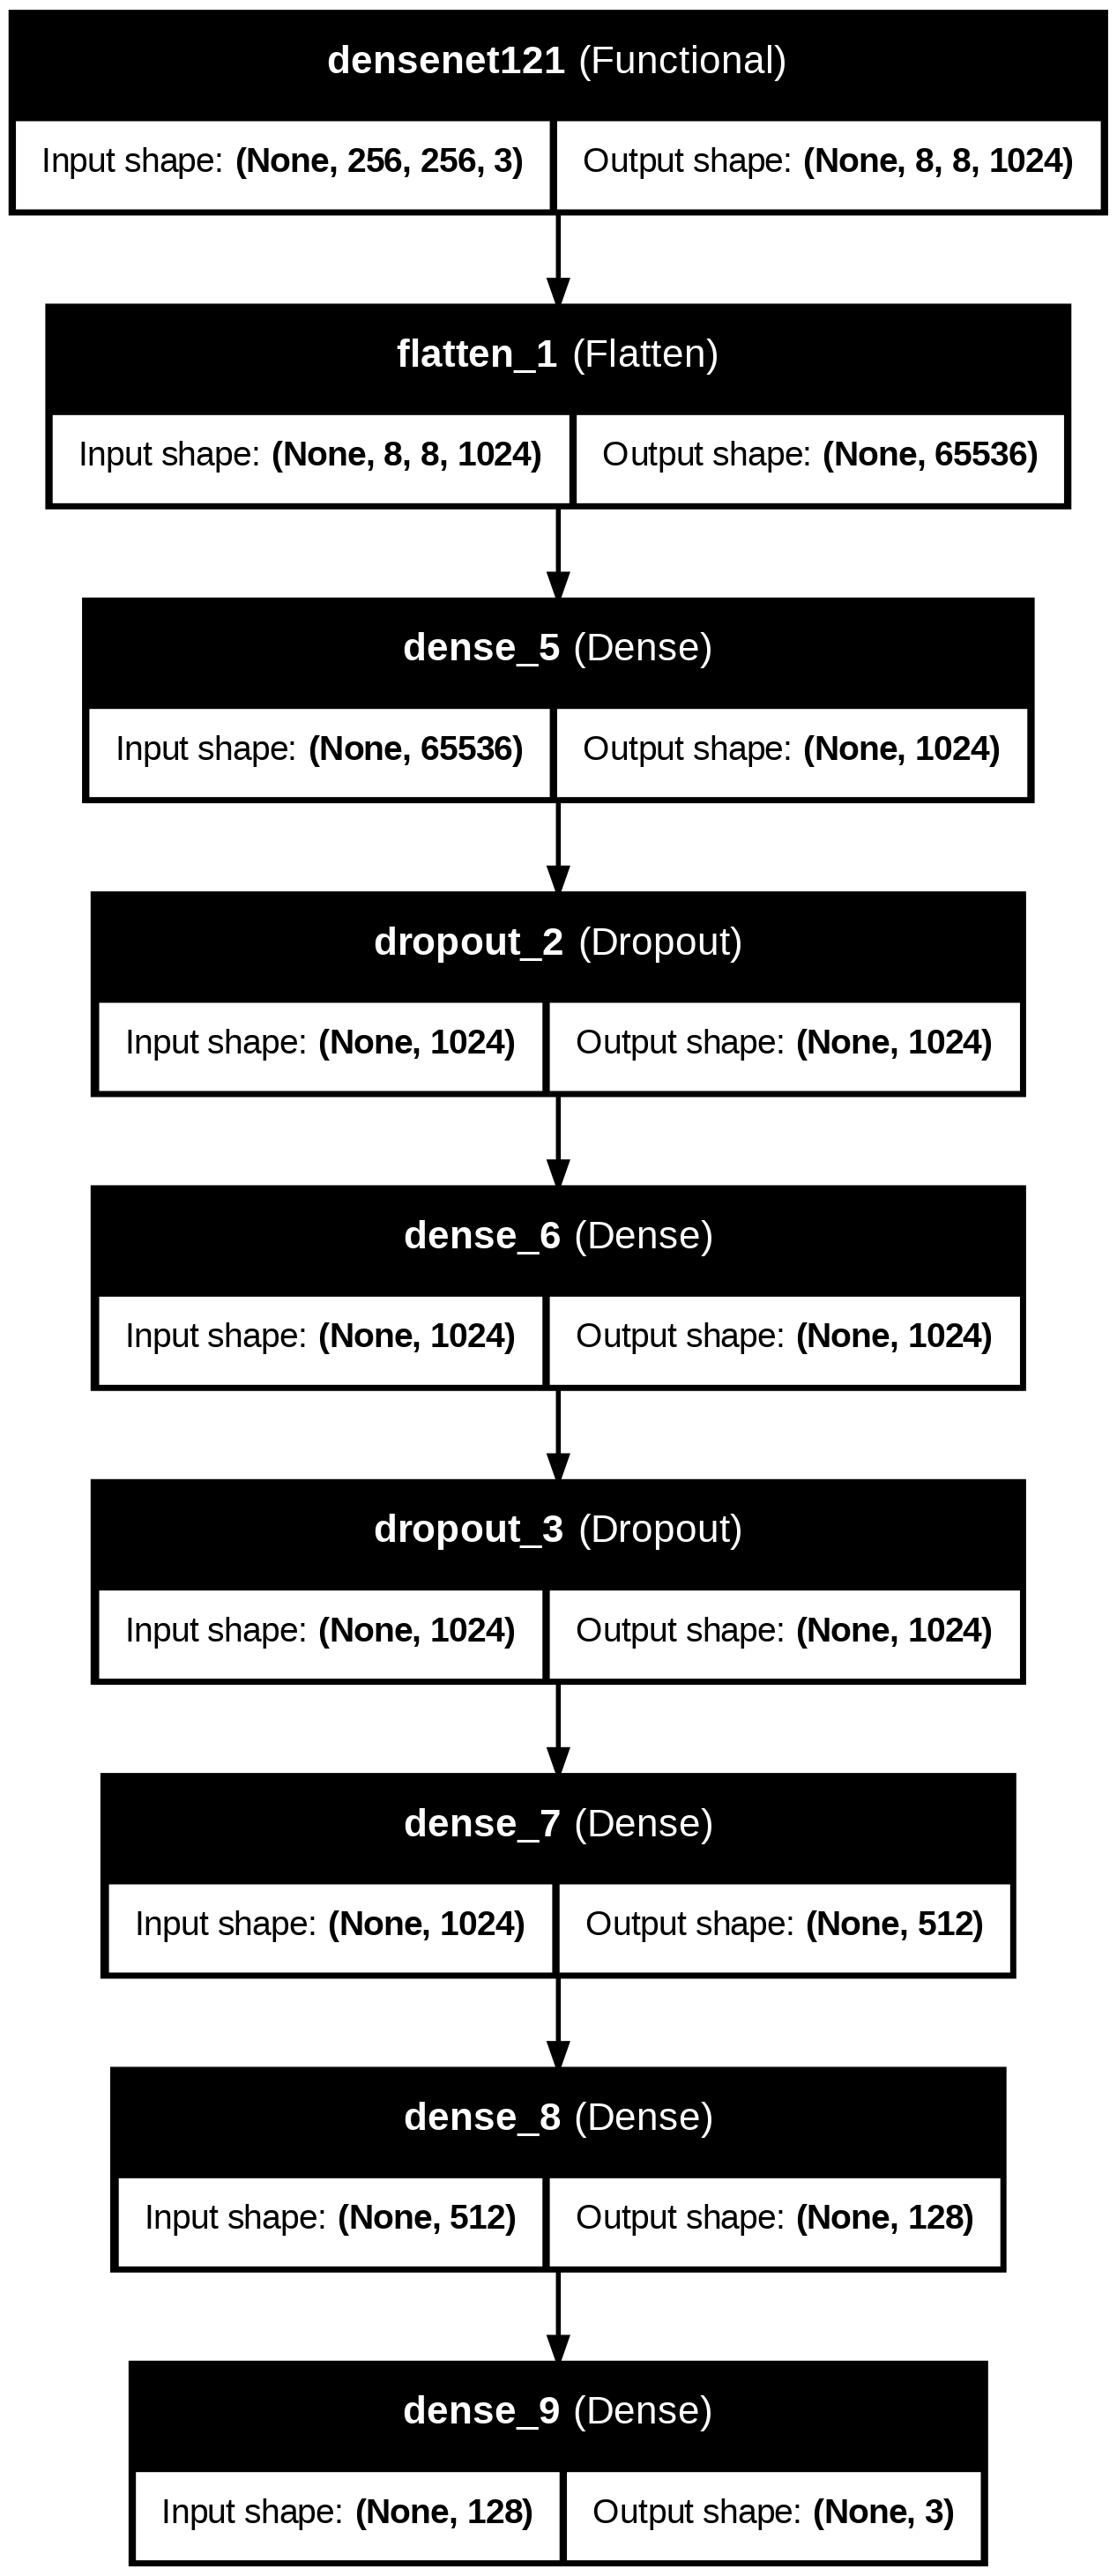

In [22]:
plot_model(model, show_shapes=True, show_layer_names=True)


In [23]:
checkpoint_path = '/content/best_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[checkpoint]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5561 - loss: 5.5462
Epoch 1: val_accuracy improved from -inf to 0.71528, saving model to /content/best_model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 71s 543ms/step - accuracy: 0.5569 - loss: 5.5183 - val_accuracy: 0.7153 - val_loss: 0.5857
Epoch 2/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8125 - loss: 1.3531

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.71528 to 0.74306, saving model to /content/best_model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.8125 - loss: 1.3531 - val_accuracy: 0.7431 - val_loss: 0.5837
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7520 - loss: 0.6777
Epoch 3: val_accuracy improved from 0.74306 to 0.80556, saving model to /content/best_model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.7522 - loss: 0.6763 - val_accuracy: 0.8056 - val_loss: 0.3776
Epoch 4/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.7500 - loss: 0.6735
Epoch 4: val_accuracy improved from 0.80556 to 0.83333, saving model to /content/best_model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.7500 - loss: 0.6735 - val_accuracy: 0.8333 - val_loss: 0.3745
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8198 - loss: 0.4396
Epoch 5: val_accuracy improved from 0.83333 to 0.86806, saving model to /content/best_model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 46s 349ms/step - accuracy: 0.8195 - loss: 0.4400 - val_accuracy: 0.8681 - val_loss: 0.3216
Epoch 6/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.8125 - loss: 0.2422
Epoch 6: val_accuracy did not improve from 0.86806
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8125 - loss: 0.2422 - val_accuracy: 0.8542 - val_loss: 0.3430
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8758 - loss: 0.3619
Epoch 7: val_accuracy did not improve from 0.86806
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.8757 - loss: 0.3617 - val_accuracy: 0.8611 - val_loss: 0.3237
Epoch 8/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8125 - loss: 0.3274
Epoch 8: val_accuracy did not improve from 0.86806
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8125 - loss: 0.3274 - val_accuracy: 0.8472 - val_loss: 0.3284
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8698 - loss: 0.3290
Epoch 9: val_accuracy improved from 0.

78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - accuracy: 0.8700 - loss: 0.3287 - val_accuracy: 0.9097 - val_loss: 0.2287
Epoch 10/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.8750 - loss: 0.2677
Epoch 10: val_accuracy improved from 0.90972 to 0.93750, saving model to /content/best_model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.8750 - loss: 0.2677 - val_accuracy: 0.9375 - val_loss: 0.2176


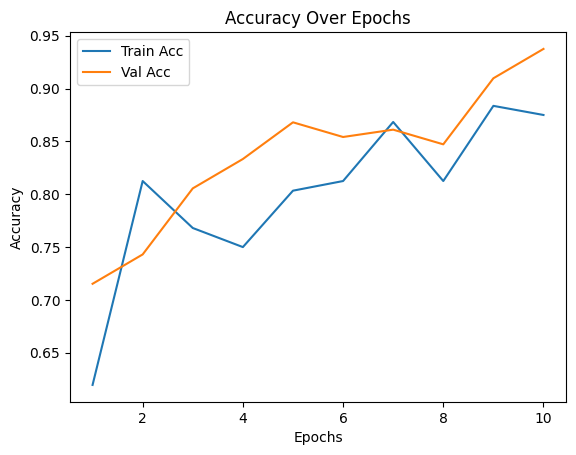

In [24]:
history_df = pd.DataFrame(history.history)
history_df['Epoch'] = range(1, len(history_df)+1)

plt.plot(history_df['Epoch'], history_df['accuracy'], label='Train Acc')
plt.plot(history_df['Epoch'], history_df['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


In [25]:
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // batch_size)
val_loss, val_accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // batch_size)

print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.9595 - loss: 0.1578
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9522 - loss: 0.2128
Train Accuracy: 95.67%
Validation Accuracy: 94.44%


Model Evaluation

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


In [50]:
# Step 1: Unzip your test dataset
zip_path = '/content/test_images.zip'
unzip_path = '/content/test_images/test_images' # Define the unzip_path

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

In [51]:
#Step 2: Load the trained model
model = load_model('/content/best_model.h5')

In [56]:
# Step 3: Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Add rescaling if not already done

test_generator = test_datagen.flow_from_directory(
    unzip_path,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',  # Must be categorical to match model's output
    shuffle=False,             # Keep shuffle=False for evaluation
    # Instead of classes=class_labels, try inferring classes:
    #classes=None  # Let the generator infer classes from subdirectories
    classes=['benign', 'malignant', 'normal'] # Explicitly specify classes
)
# Print the found classes to check:
print("Classes found by test_generator:", test_generator.class_indices)

Found 158 images belonging to 3 classes.
Classes found by test_generator: {'benign': 0, 'malignant': 1, 'normal': 2}


In [58]:
# Step 4: Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
accuracy_percent = test_accuracy * 100

# Display test evaluation
evaluation_result = pd.DataFrame({
    'Set': ['Test'],
    'Loss': [test_loss],
    'Accuracy': [f'{accuracy_percent:.2f}%']
})
print(evaluation_result)



10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9359 - loss: 0.2645
    Set      Loss Accuracy
0  Test  0.305985   91.77%


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


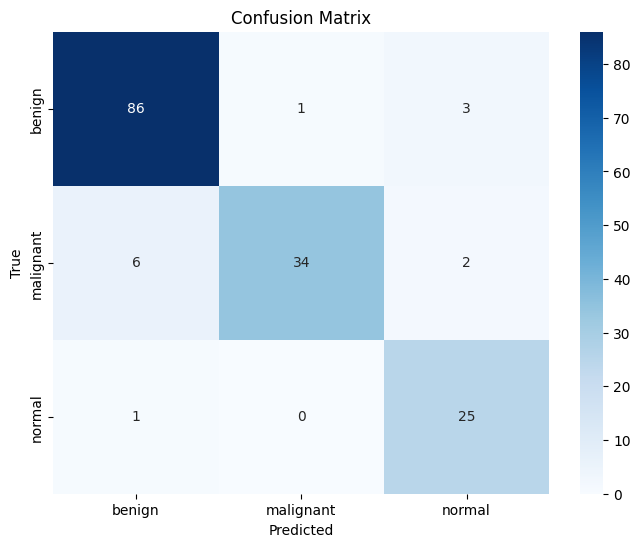


Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.96      0.94        90
   malignant       0.97      0.81      0.88        42
      normal       0.83      0.96      0.89        26

    accuracy                           0.92       158
   macro avg       0.91      0.91      0.91       158
weighted avg       0.92      0.92      0.92       158


Overall Test Accuracy: 91.77%


In [59]:
# Step 5: Confusion Matrix & Classification Report
class_names = ['benign', 'malignant', 'normal']

predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

print(f"\nOverall Test Accuracy: {accuracy_percent:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Real Class: malignant
Predicted Class: malignant
"Correct"



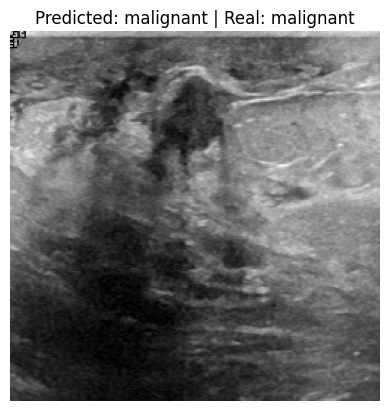

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Real Class: normal
Predicted Class: normal
"Correct"



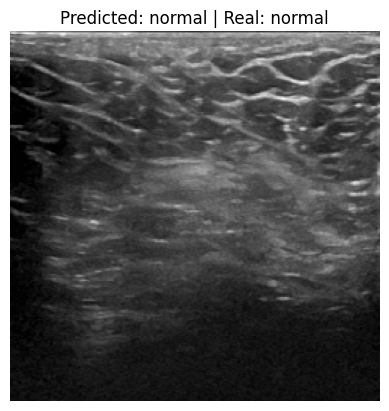

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Real Class: benign
Predicted Class: benign
"Correct"



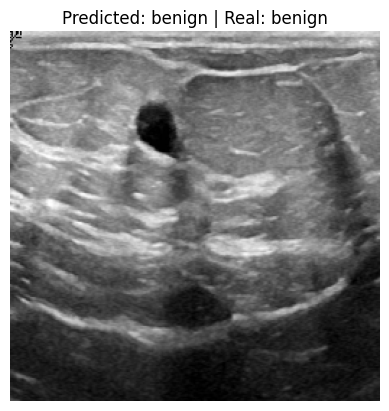

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Real Class: malignant
Predicted Class: malignant
"Correct"



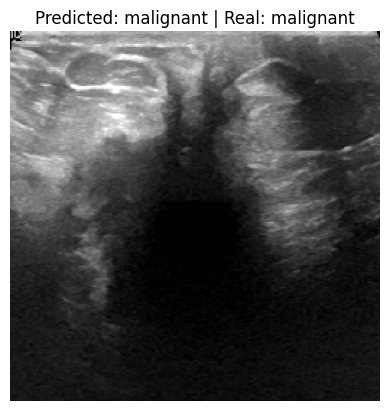

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Real Class: benign
Predicted Class: benign
"Correct"



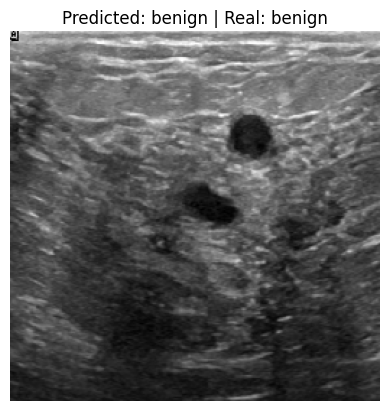

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Real Class: normal
Predicted Class: normal
"Correct"



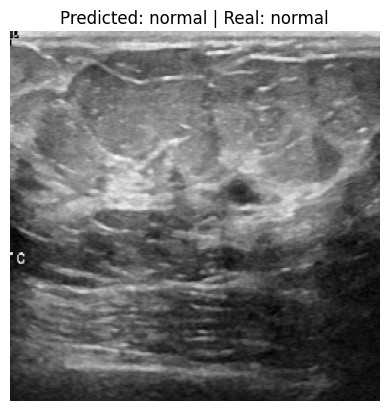


✅ 6 out of 6 images classified correctly.


In [64]:
#Step 6: Predict specific images manually
image_paths = [
    '/content/test_images/test_images/malignant/malignant (46).png',
    '/content/test_images/test_images/normal/normal (91).png',
    '/content/test_images/test_images/benign/benign (78).png',
    '/content/test_images/test_images/malignant/malignant (30).png',
    '/content/test_images/test_images/benign/benign (166).png',
    '/content/test_images/test_images/normal/normal (122).png',

]

class_labels = {0: 'benign', 1: 'malignant', 2: 'normal'}
correct_predictions = 0

for img_path in image_paths:
    real_class = img_path.split('/')[-2]

    img = load_img(img_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]

    correctness = '"Correct"' if real_class == predicted_class.lower() else '"Incorrect"'

    print(f'Real Class: {real_class}')
    print(f'Predicted Class: {predicted_class}')
    print(f'{correctness}\n')

    if correctness == '"Correct"':
        correct_predictions += 1

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class} | Real: {real_class}')
    plt.show()

print(f'\n✅ {correct_predictions} out of {len(image_paths)} images classified correctly.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
🔍 Predicted Class: benign
📊 Confidence: 94.22%


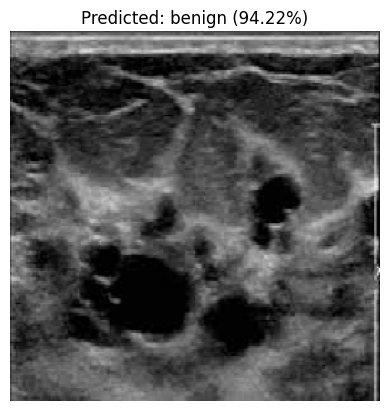

In [65]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Replace with the path to your downloaded image
image_paths = [
    '/content/images.jpeg',  # Replace this with your uploaded image path
]

class_labels = {0: 'benign', 1: 'malignant', 2: 'normal'}

for img_path in image_paths:
    img = load_img(img_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]
    confidence = prediction[0][predicted_index] * 100

    print(f'🔍 Predicted Class: {predicted_class}')
    print(f'📊 Confidence: {confidence:.2f}%')

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class} ({confidence:.2f}%)')
    plt.show()
